# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

%matplotlib inline

import numpy as np
import pandas as pd

In this lab, we will explore a dataset that describes websites with different features and labels them either benign or malicious . We will use supervised learning algorithms to figure out what feature patterns malicious websites are likely to have and use our model to predict malicious websites.

# Challenge 1 - Explore The Dataset

Let's start by exploring the dataset. First load the data file:

In [2]:
websites = pd.read_csv('../website.csv')

#### Explore the data from an bird's-eye view.

You should already been very familiar with the procedures now so we won't provide the instructions step by step. Reflect on what you did in the previous labs and explore the dataset.

Things you'll be looking for:

* What the dataset looks like?
* What are the data types?
* Which columns contain the features of the websites?
* Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
* Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?

Feel free to add additional cells for your explorations. Make sure to comment what you find out.

In [3]:
websites.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,...,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,2,5,4278,61,62,129889,4586,61,4.0,0


In [4]:
websites.dtypes

URL                           object
URL_LENGTH                     int64
NUMBER_SPECIAL_CHARACTERS      int64
CHARSET                       object
SERVER                        object
CONTENT_LENGTH               float64
WHOIS_COUNTRY                 object
WHOIS_STATEPRO                object
WHOIS_REGDATE                 object
WHOIS_UPDATED_DATE            object
TCP_CONVERSATION_EXCHANGE      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
SOURCE_APP_PACKETS             int64
REMOTE_APP_PACKETS             int64
SOURCE_APP_BYTES               int64
REMOTE_APP_BYTES               int64
APP_PACKETS                    int64
DNS_QUERY_TIMES              float64
Type                           int64
dtype: object

In [5]:
websites.columns

Index(['URL', 'URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'CHARSET', 'SERVER',
       'CONTENT_LENGTH', 'WHOIS_COUNTRY', 'WHOIS_STATEPRO', 'WHOIS_REGDATE',
       'WHOIS_UPDATED_DATE', 'TCP_CONVERSATION_EXCHANGE',
       'DIST_REMOTE_TCP_PORT', 'REMOTE_IPS', 'APP_BYTES', 'SOURCE_APP_PACKETS',
       'REMOTE_APP_PACKETS', 'SOURCE_APP_BYTES', 'REMOTE_APP_BYTES',
       'APP_PACKETS', 'DNS_QUERY_TIMES', 'Type'],
      dtype='object')

In [6]:
websites['Type'].value_counts()

0    1565
1     216
Name: Type, dtype: int64

In [7]:
websites['Type'].value_counts()

0    1565
1     216
Name: Type, dtype: int64

In [8]:
websites.isnull().sum()


URL                            0
URL_LENGTH                     0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        0
SERVER                         1
CONTENT_LENGTH               812
WHOIS_COUNTRY                  0
WHOIS_STATEPRO                 0
WHOIS_REGDATE                  0
WHOIS_UPDATED_DATE             0
TCP_CONVERSATION_EXCHANGE      0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
SOURCE_APP_PACKETS             0
REMOTE_APP_PACKETS             0
SOURCE_APP_BYTES               0
REMOTE_APP_BYTES               0
APP_PACKETS                    0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64

In [9]:
websites.drop('CONTENT_LENGTH', axis=1, inplace=True)

In [10]:
websites.dropna(inplace=True)

In [11]:
websites.isnull().sum()

URL                          0
URL_LENGTH                   0
NUMBER_SPECIAL_CHARACTERS    0
CHARSET                      0
SERVER                       0
WHOIS_COUNTRY                0
WHOIS_STATEPRO               0
WHOIS_REGDATE                0
WHOIS_UPDATED_DATE           0
TCP_CONVERSATION_EXCHANGE    0
DIST_REMOTE_TCP_PORT         0
REMOTE_IPS                   0
APP_BYTES                    0
SOURCE_APP_PACKETS           0
REMOTE_APP_PACKETS           0
SOURCE_APP_BYTES             0
REMOTE_APP_BYTES             0
APP_PACKETS                  0
DNS_QUERY_TIMES              0
Type                         0
dtype: int64

#### Next, evaluate if the columns in this dataset are strongly correlated.

In the Mushroom supervised learning lab we did recently, we mentioned we are concerned if our dataset has strongly correlated columns because if it is the case we need to choose certain ML algorithms instead of others. We need to evaluate this for our dataset now.

Luckily, most of the columns in this dataset are ordinal which makes things a lot easier for us. In the next cells below, evaluate the level of collinearity of the data.

We provide some general directions for you to consult in order to complete this step:

1. You will create a correlation matrix using the numeric columns in the dataset.

1. Create a heatmap using `seaborn` to visualize which columns have high collinearity.

1. Comment on which columns you might need to remove due to high collinearity.

In [12]:
websites.corr()

C:\Users\gdlcm\AppData\Local\Temp\ipykernel_197884\2867562932.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  websites.corr()


,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
URL_LENGTH,1.000000,0.918098,-0.038159,-0.039696,-0.046174,-0.026416,-0.041967,-0.033481,-0.014628,-0.026652,-0.041967,-0.068453,0.162641
NUMBER_SPECIAL_CHARACTERS,0.918098,1.000000,-0.037323,-0.042554,-0.046961,-0.023896,-0.039939,-0.030467,-0.014276,-0.024079,-0.039939,-0.050067,0.281150
TCP_CONVERSATION_EXCHANGE,-0.038159,-0.037323,1.000000,0.555180,0.331057,0.457324,0.997798,0.990871,0.865585,0.458705,0.997798,0.349877,-0.040276
DIST_REMOTE_TCP_PORT,-0.039696,-0.042554,0.555180,1.000000,0.210198,0.780243,0.558601,0.591173,0.313333,0.781216,0.558601,0.259919,-0.082999
REMOTE_IPS,-0.046174,-0.046961,0.331057,0.210198,1.000000,0.023124,0.361087,0.304712,0.171660,0.025322,0.361087,0.548413,-0.078801
APP_BYTES,-0.026416,-0.023896,0.457324,0.780243,0.023124,1.000000,0.445828,0.469010,0.074456,0.999992,0.445828,0.012208,-0.011281
SOURCE_APP_PACKETS,-0.041967,-0.039939,0.997798,0.558601,0.361087,0.445828,1.000000,0.989300,0.857496,0.447453,1.000000,0.410876,-0.034509
REMOTE_APP_PACKETS,-0.033481,-0.030467,0.990871,0.591173,0.304712,0.469010,0.989300,1.000000,0.880550,0.470412,0.989300,0.355648,-0.033029
SOURCE_APP_BYTES,-0.014628,-0.014276,0.865585,0.313333,0.171660,0.074456,0.857496,0.880550,1.000000,0.075319,0.857496,0.215227,-0.043949
REMOTE_APP_BYTES,-0.026652,-0.024079,0.458705,0.781216,0.025322,0.999992,0.447453,0.470412,0.075319,1.000000,0.447453,0.016201,-0.011024


C:\Users\gdlcm\AppData\Local\Temp\ipykernel_197884\2174795843.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(websites.corr(), annot=True, cmap='coolwarm')


<AxesSubplot: >

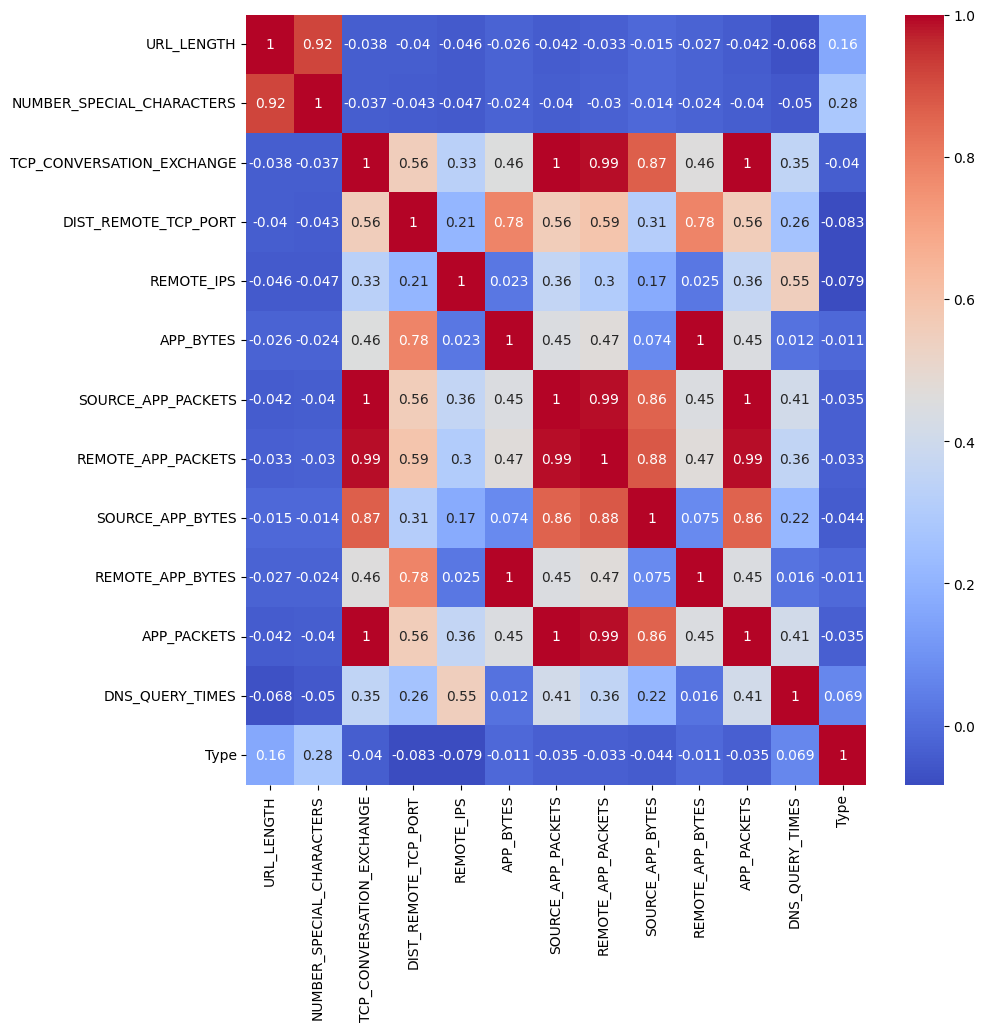

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
sns.heatmap(websites.corr(), annot=True, cmap='coolwarm')

# Challenge 2 - Remove Column Collinearity.

From the heatmap you created, you should have seen at least 3 columns that can be removed due to high collinearity. Remove these columns from the dataset.

Note that you should remove as few columns as you can. You don't have to remove all the columns at once. But instead, try removing one column, then produce the heatmap again to determine if additional columns should be removed. As long as the dataset no longer contains columns that are correlated for over 90%, you can stop. Also, keep in mind when two columns have high collinearity, you only need to remove one of them but not both.

In the cells below, remove as few columns as you can to eliminate the high collinearity in the dataset. Make sure to comment on your way so that the instructional team can learn about your thinking process which allows them to give feedback. At the end, print the heatmap again.

In [14]:
websites.drop(['TCP_CONVERSATION_EXCHANGE', 'REMOTE_APP_PACKETS', 'APP_PACKETS'], axis=1, inplace=True)

C:\Users\gdlcm\AppData\Local\Temp\ipykernel_197884\3581805834.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(websites.corr(), annot=True, cmap='coolwarm')


<AxesSubplot: >

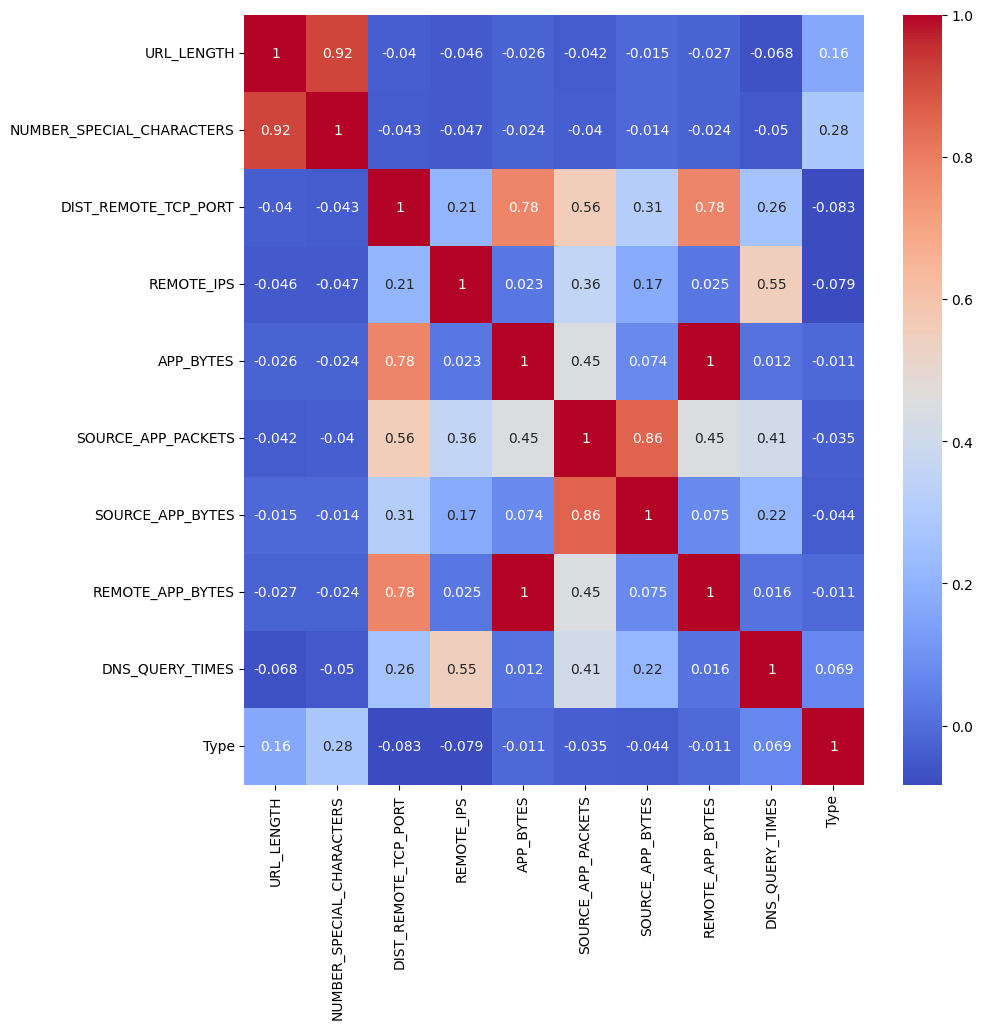

In [15]:
plt.figure(figsize=(10,10))
sns.heatmap(websites.corr(), annot=True, cmap='coolwarm')

In [16]:
# Print heatmap again
websites.drop(['NUMBER_SPECIAL_CHARACTERS', 'APP_BYTES'], axis=1, inplace=True)

C:\Users\gdlcm\AppData\Local\Temp\ipykernel_197884\3581805834.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(websites.corr(), annot=True, cmap='coolwarm')


<AxesSubplot: >

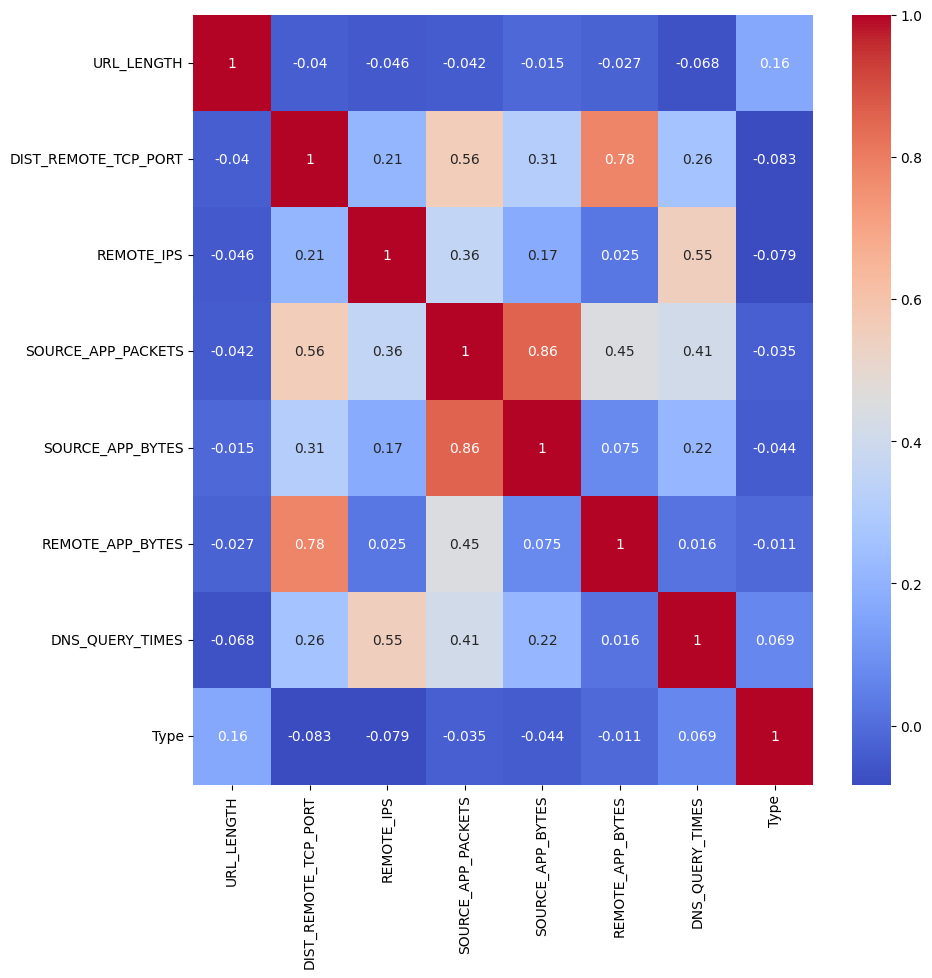

In [17]:
plt.figure(figsize=(10,10))
sns.heatmap(websites.corr(), annot=True, cmap='coolwarm')

# Challenge 3 - Handle Missing Values

The next step would be handling missing values. **We start by examining the number of missing values in each column, which you will do in the next cell.**

If you remember in the previous labs, we drop a column if the column contains a high proportion of missing values. After dropping those problematic columns, we drop the rows with missing values.

#### In the cells below, handle the missing values from the dataset. Remember to comment the rationale of your decisions.

#### Again, examine the number of missing values in each column. 

If all cleaned, proceed. Otherwise, go back and do more cleaning.

In [18]:
websites.isnull().sum()

URL                     0
URL_LENGTH              0
CHARSET                 0
SERVER                  0
WHOIS_COUNTRY           0
WHOIS_STATEPRO          0
WHOIS_REGDATE           0
WHOIS_UPDATED_DATE      0
DIST_REMOTE_TCP_PORT    0
REMOTE_IPS              0
SOURCE_APP_PACKETS      0
SOURCE_APP_BYTES        0
REMOTE_APP_BYTES        0
DNS_QUERY_TIMES         0
Type                    0
dtype: int64

# Challenge 4 - Handle `WHOIS_*` Categorical Data

There are several categorical columns we need to handle. These columns are:

* `URL`
* `CHARSET`
* `SERVER`
* `WHOIS_COUNTRY`
* `WHOIS_STATEPRO`
* `WHOIS_REGDATE`
* `WHOIS_UPDATED_DATE`

How to handle string columns is always case by case. Let's start by working on `WHOIS_COUNTRY`. Your steps are:

1. List out the unique values of `WHOIS_COUNTRY`.
1. Consolidate the country values with consistent country codes. For example, the following values refer to the same country and should use consistent country code:
    * `CY` and `Cyprus`
    * `US` and `us`
    * `SE` and `se`
    * `GB`, `United Kingdom`, and `[u'GB'; u'UK']`

#### In the cells below, fix the country values as intructed above.

In [19]:
websites['WHOIS_COUNTRY'].value_counts()

US                1102
None               306
CA                  83
ES                  63
AU                  35
PA                  21
GB                  19
JP                  11
CN                  10
IN                  10
UK                  10
FR                   9
CZ                   9
NL                   6
CH                   6
KR                   5
[u'GB'; u'UK']       5
ru                   4
PH                   4
BS                   4
AT                   4
KY                   3
SE                   3
BE                   3
SC                   3
TR                   3
DE                   3
HK                   3
us                   3
IL                   2
SI                   2
UY                   2
Cyprus               2
RU                   2
UA                   2
KG                   2
BR                   2
NO                   2
LU                   1
LV                   1
United Kingdom       1
PK                   1
IT                   1
TH         

In [20]:
websites['WHOIS_COUNTRY'] = websites['WHOIS_COUNTRY'].replace('Cyprus', 'CY')
websites['WHOIS_COUNTRY'].value_counts()
websites['WHOIS_COUNTRY'] = websites['WHOIS_COUNTRY'].replace('United Kingdom', 'UK')
websites['WHOIS_COUNTRY'].value_counts()
websites['WHOIS_COUNTRY'] = websites['WHOIS_COUNTRY'].replace('GB', 'UK')
websites['WHOIS_COUNTRY'].value_counts()
websites['WHOIS_COUNTRY'] = websites['WHOIS_COUNTRY'].replace('[u\'GB\'; u\'UK\']', 'UK')
websites['WHOIS_COUNTRY'].value_counts()
websites['WHOIS_COUNTRY'] = websites['WHOIS_COUNTRY'].replace('us', 'US')
websites['WHOIS_COUNTRY'].value_counts()
websites['WHOIS_COUNTRY'] = websites['WHOIS_COUNTRY'].replace('se', 'SE')
websites['WHOIS_COUNTRY'].value_counts()


US      1105
None     306
CA        83
ES        63
UK        35
AU        35
PA        21
JP        11
CN        10
IN        10
FR         9
CZ         9
NL         6
CH         6
KR         5
AT         4
PH         4
SE         4
BS         4
ru         4
TR         3
HK         3
BE         3
DE         3
KY         3
SC         3
UA         2
BR         2
CY         2
UY         2
KG         2
NO         2
RU         2
IL         2
SI         2
LV         1
PK         1
IT         1
LU         1
BY         1
AE         1
IE         1
UG         1
TH         1
Name: WHOIS_COUNTRY, dtype: int64

In [21]:
websites['WHOIS_COUNTRY'].value_counts()

US      1105
None     306
CA        83
ES        63
UK        35
AU        35
PA        21
JP        11
CN        10
IN        10
FR         9
CZ         9
NL         6
CH         6
KR         5
AT         4
PH         4
SE         4
BS         4
ru         4
TR         3
HK         3
BE         3
DE         3
KY         3
SC         3
UA         2
BR         2
CY         2
UY         2
KG         2
NO         2
RU         2
IL         2
SI         2
LV         1
PK         1
IT         1
LU         1
BY         1
AE         1
IE         1
UG         1
TH         1
Name: WHOIS_COUNTRY, dtype: int64

Since we have fixed the country values, can we convert this column to ordinal now?

Not yet. If you reflect on the previous labs how we handle categorical columns, you probably remember we ended up dropping a lot of those columns because there are too many unique values. Too many unique values in a column is not desirable in machine learning because it makes prediction inaccurate. But there are workarounds under certain conditions. One of the fixable conditions is:

#### If a limited number of values account for the majority of data, we can retain these top values and re-label all other rare values.

The `WHOIS_COUNTRY` column happens to be this case. You can verify it by print a bar chart of the `value_counts` in the next cell to verify:

<AxesSubplot: >

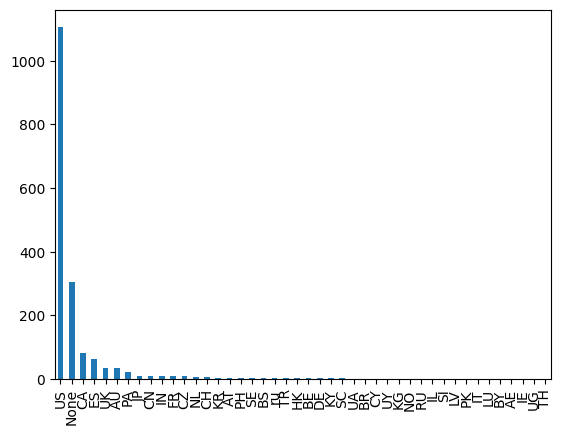

In [22]:
websites['WHOIS_COUNTRY'].value_counts().plot(kind='bar')

#### After verifying, now let's keep the top 10 values of the column and re-label other columns with `OTHER`.

In [23]:
top10 = websites['WHOIS_COUNTRY'].value_counts().head(10)
top10

US      1105
None     306
CA        83
ES        63
UK        35
AU        35
PA        21
JP        11
CN        10
IN        10
Name: WHOIS_COUNTRY, dtype: int64

In [24]:
websites['WHOIS_COUNTRY'] = websites['WHOIS_COUNTRY'].apply(lambda x: x if x in top10 else 'OTHER')
websites['WHOIS_COUNTRY'].value_counts()

US       1105
None      306
OTHER     100
CA         83
ES         63
UK         35
AU         35
PA         21
JP         11
IN         10
CN         10
Name: WHOIS_COUNTRY, dtype: int64

Now since `WHOIS_COUNTRY` has been re-labelled, we don't need `WHOIS_STATEPRO` any more because the values of the states or provinces may not be relevant any more. We'll drop this column.

In addition, we will also drop `WHOIS_REGDATE` and `WHOIS_UPDATED_DATE`. These are the registration and update dates of the website domains. Not of our concerns.

#### In the next cell, drop `['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']`.

In [25]:
websites.drop(['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE'], axis=1, inplace=True)

# Challenge 5 - Handle Remaining Categorical Data & Convert to Ordinal

Now print the `dtypes` of the data again. Besides `WHOIS_COUNTRY` which we already fixed, there should be 3 categorical columns left: `URL`, `CHARSET`, and `SERVER`.

In [26]:
websites.dtypes

URL                      object
URL_LENGTH                int64
CHARSET                  object
SERVER                   object
WHOIS_COUNTRY            object
DIST_REMOTE_TCP_PORT      int64
REMOTE_IPS                int64
SOURCE_APP_PACKETS        int64
SOURCE_APP_BYTES          int64
REMOTE_APP_BYTES          int64
DNS_QUERY_TIMES         float64
Type                      int64
dtype: object

#### `URL` is easy. We'll simply drop it because it has too many unique values that there's no way for us to consolidate.

In [27]:
websites.drop('URL', axis=1, inplace=True)

#### Print the unique value counts of `CHARSET`. You see there are only a few unique values. So we can keep it as it is.

In [28]:
websites['CHARSET'].value_counts()

UTF-8           674
ISO-8859-1      427
utf-8           379
us-ascii        155
iso-8859-1      134
None              7
windows-1251      1
ISO-8859          1
windows-1252      1
Name: CHARSET, dtype: int64

`SERVER` is a little more complicated. Print its unique values and think about how you can consolidate those values.

#### Before you think of your own solution, don't read the instructions that come next.

In [29]:
websites['SERVER'].value_counts()

Apache                                                                             385
nginx                                                                              211
None                                                                               175
Microsoft-HTTPAPI/2.0                                                              113
cloudflare-nginx                                                                    94
                                                                                  ... 
Apache/2.2.29 (Unix) mod_ssl/2.2.29 OpenSSL/1.0.1e-fips DAV/2 mod_bwlimited/1.4      1
gunicorn/19.7.1                                                                      1
Apache/2.2.31 (Unix) mod_ssl/2.2.31 OpenSSL/0.9.8e-fips-rhel5 mod_bwlimited/1.4      1
Apache/1.3.37 (Unix) mod_perl/1.29 mod_ssl/2.8.28 OpenSSL/0.9.7e-p1                  1
Apache/2.2.16 (Debian)                                                               1
Name: SERVER, Length: 239, dtype: int64

In [30]:
websites['SERVER'] = websites['SERVER'].apply(lambda x: 'Apache' if 'Apache' in x else x)
websites['SERVER'] = websites['SERVER'].apply(lambda x: 'Microsoft' if 'Microsoft' in x else x)
websites['SERVER'] = websites['SERVER'].apply(lambda x: 'nginx' if 'nginx' in x else x)
websites['SERVER'] = websites['SERVER'].apply(lambda x: 'Other' if x not in ['Apache', 'Microsoft', 'nginx'] else x)



In [31]:
websites['SERVER'].value_counts()

Apache       642
Other        504
nginx        435
Microsoft    198
Name: SERVER, dtype: int64

![Think Hard](../think-hard.jpg)

Although there are so many unique values in the `SERVER` column, there are actually only 3 main server types: `Microsoft`, `Apache`, and `nginx`. Just check if each `SERVER` value contains any of those server types and re-label them. For `SERVER` values that don't contain any of those substrings, label with `Other`.

At the end, your `SERVER` column should only contain 4 unique values: `Microsoft`, `Apache`, `nginx`, and `Other`.

In [32]:
websites['SERVER'].value_counts()

Apache       642
Other        504
nginx        435
Microsoft    198
Name: SERVER, dtype: int64

OK, all our categorical data are fixed now. **Let's convert them to ordinal data using Pandas' `get_dummies` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)).** Make sure you drop the categorical columns by passing `drop_first=True` to `get_dummies` as we don't need them any more. **Also, assign the data with dummy values to a new variable `website_dummy`.**

In [33]:
websites = pd.get_dummies(websites, columns=['CHARSET', 'SERVER', 'WHOIS_COUNTRY'], drop_first=True)
website_dummy = pd.get_dummies(websites, drop_first=True)
website_dummy.head()


,URL_LENGTH,DIST_REMOTE_TCP_PORT,REMOTE_IPS,SOURCE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,DNS_QUERY_TIMES,Type,CHARSET_ISO-8859-1,CHARSET_None,...,WHOIS_COUNTRY_CA,WHOIS_COUNTRY_CN,WHOIS_COUNTRY_ES,WHOIS_COUNTRY_IN,WHOIS_COUNTRY_JP,WHOIS_COUNTRY_None,WHOIS_COUNTRY_OTHER,WHOIS_COUNTRY_PA,WHOIS_COUNTRY_UK,WHOIS_COUNTRY_US
0,16,0,2,9,1153,832,2.0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,16,7,4,17,1265,1230,0.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,16,0,0,0,0,0,0.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,17,22,3,39,18784,4380,8.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,17,2,5,61,129889,4586,4.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Now, inspect `website_dummy` to make sure the data and types are intended - there shouldn't be any categorical columns at this point.

In [34]:
website_dummy.dtypes

URL_LENGTH                int64
DIST_REMOTE_TCP_PORT      int64
REMOTE_IPS                int64
SOURCE_APP_PACKETS        int64
SOURCE_APP_BYTES          int64
REMOTE_APP_BYTES          int64
DNS_QUERY_TIMES         float64
Type                      int64
CHARSET_ISO-8859-1        uint8
CHARSET_None              uint8
CHARSET_UTF-8             uint8
CHARSET_iso-8859-1        uint8
CHARSET_us-ascii          uint8
CHARSET_utf-8             uint8
CHARSET_windows-1251      uint8
CHARSET_windows-1252      uint8
SERVER_Microsoft          uint8
SERVER_Other              uint8
SERVER_nginx              uint8
WHOIS_COUNTRY_CA          uint8
WHOIS_COUNTRY_CN          uint8
WHOIS_COUNTRY_ES          uint8
WHOIS_COUNTRY_IN          uint8
WHOIS_COUNTRY_JP          uint8
WHOIS_COUNTRY_None        uint8
WHOIS_COUNTRY_OTHER       uint8
WHOIS_COUNTRY_PA          uint8
WHOIS_COUNTRY_UK          uint8
WHOIS_COUNTRY_US          uint8
dtype: object

# Challenge 6 - Modeling, Prediction, and Evaluation

We'll start off this section by splitting the data to train and test. **Name your 4 variables `X_train`, `X_test`, `y_train`, and `y_test`. Select 80% of the data for training and 20% for testing.**

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(website_dummy.drop('Type', axis=1), website_dummy['Type'], test_size=0.2, random_state=0)


#### In this lab, we will try two different models and compare our results.

The first model we will use in this lab is logistic regression. We have previously learned about logistic regression as a classification algorithm. In the cell below, load `LogisticRegression` from scikit-learn and initialize the model.

In [36]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()


Next, fit the model to our training data. We have already separated our data into 4 parts. Use those in your model.

In [37]:
logreg.fit(X_train, y_train)
logreg.score(X_train, y_train)

C:\Users\gdlcm\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8812368236120871

finally, import `confusion_matrix` and `accuracy_score` from `sklearn.metrics` and fit our testing data. Assign the fitted data to `y_pred` and print the confusion matrix as well as the accuracy score

In [38]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = logreg.predict(X_test)
confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       317
           1       0.59      0.33      0.43        39

    accuracy                           0.90       356
   macro avg       0.76      0.65      0.69       356
weighted avg       0.89      0.90      0.89       356



What are your thoughts on the performance of the model? Write your conclusions below.

#### Our second algorithm is is K-Nearest Neighbors. 

Though is it not required, we will fit a model using the training data and then test the performance of the model using the testing data. Start by loading `KNeighborsClassifier` from scikit-learn and then initializing and fitting the model. We'll start off with a model where k=3.

In [39]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn.score(X_train, y_train)



0.955024595924104

To test your model, compute the predicted values for the testing sample and print the confusion matrix as well as the accuracy score.

In [40]:
y_pred = knn.predict(X_test)
confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.97      0.97       317
           1       0.75      0.69      0.72        39

    accuracy                           0.94       356
   macro avg       0.86      0.83      0.84       356
weighted avg       0.94      0.94      0.94       356



#### We'll create another K-Nearest Neighbors model with k=5. 

Initialize and fit the model below and print the confusion matrix and the accuracy score.

In [41]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn.score(X_train, y_train)
y_pred = knn.predict(X_test)
confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.98      0.97       317
           1       0.79      0.67      0.72        39

    accuracy                           0.94       356
   macro avg       0.87      0.82      0.85       356
weighted avg       0.94      0.94      0.94       356



Did you see an improvement in the confusion matrix when increasing k to 5? Did you see an improvement in the accuracy score? Write your conclusions below.

# Bonus Challenge - Feature Scaling

Problem-solving in machine learning is iterative. You can improve your model prediction with various techniques (there is a sweetspot for the time you spend and the improvement you receive though). Now you've completed only one iteration of ML analysis. There are more iterations you can conduct to make improvements. In order to be able to do that, you will need deeper knowledge in statistics and master more data analysis techniques. In this bootcamp, we don't have time to achieve that advanced goal. But you will make constant efforts after the bootcamp to eventually get there.

However, now we do want you to learn one of the advanced techniques which is called *feature scaling*. The idea of feature scaling is to standardize/normalize the range of independent variables or features of the data. This can make the outliers more apparent so that you can remove them. This step needs to happen during Challenge 6 after you split the training and test data because you don't want to split the data again which makes it impossible to compare your results with and without feature scaling. For general concepts about feature scaling, click [here](https://en.wikipedia.org/wiki/Feature_scaling). To read deeper, click [here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e).

In the next cell, attempt to improve your model prediction accuracy by means of feature scaling. A library you can utilize is `sklearn.preprocessing.RobustScaler` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)). You'll use the `RobustScaler` to fit and transform your `X_train`, then transform `X_test`. You will use logistic regression to fit and predict your transformed data and obtain the accuracy score in the same way. Compare the accuracy score with your normalized data with the previous accuracy data. Is there an improvement?

In [42]:
# Your code here